# Tensorflow Deep-Learning | Multi-Node / Multi-GPU | Docker 

***


Hier wird ein Template vorstellen, womit man verteilt auf GPUs trainieren kann. Wir nutzen Tensorflow für die Netzwerke und Dask für die Verteilung.

Von TensorFlow selber gibt es euch einige Anwendungsbeispiele für Deep-Learning.
Saturncloud stellt uns Module bereit, einer dieser Module nennt sich Dask-PyTorch-DDP, was wir für das Trainieren mit Dask nutzen werden (für TensorFlow anwendbar). Das Modul wurde an Tensorflow angepasst. Ob Docker oder nicht, es muss ein Dask-Cluster erstellt werden, damit das mit Dask und TensorFlow funktioniert. Die Worker sollten auf die GPU zugreifen können. 


Das verteilte Trainieren erfolgt so, dass wir unser Model auf jeden Worker kopieren und ein Teil der Trainingsdaten nutzen. Details zu den Strategien werden folgen. Das Verteilen findet im Hintergrund statt.

<u>Wann sollte TensorFlow MultiWorkerMirroredStrategy genutzt werden:<u><br>
- Das Model passt auf eine GPU
- Es gibt sehr viele Trainingsdaten.<br>
Die Strategie beschleunigt das Training, indem jeder erstellte Worker das gleiche Model mit unterschiedlichen Daten trainiert. Die Gradienten werden gemittelt. 

<br>

Dask und Dask.distributed sollten die gleiche Version haben.     <br>
Dask: https://www.dask.orgund& https://docs.dask.org/en/stable/  
Saturncloud Module https://github.com/saturncloud/dask-pytorch-ddp<br>
Tensorflow: https://www.tensorflow.org <br>
TensorFlow Versionen: https://www.tensorflow.org/versions >

# 1. Tensorflow und Dask

Um einen einfachen Einblick zu bekommen, wird das TensorFlow Basic Beispiel genutzt. Die weiteren Details werden folgen.
Die genutzte Strategie ist `tf.distribute.MultiWorkerMirroredStrategy`.

Für das verteilte Trainieren müssen bestimmte Umgebungsvariablen gesetzet werden. Damit kann festgestellt werden, wer Worker ist und wer Chief ist. Diese Einstellungen werden im Hintergrund vorgenommen.

Wir teilen das Training in 4 Bereiche auf. Hier nutzen wir MNSG.

<img src="./pictures/rapids_flynn.PNG"  width="625px;" hight="625px;">

<br>

Multi-worker training with Keras: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#multi-worker_configuration

## 1.1 Strategie

Für den Basisfall, dass unser Model auf eine GPU passt, werden wir die Strategie MultiWorkerMirroredStrategy anwenden. Diese kopiert auf jeden Worker das Model. Dann werden die Lokalen Daten für das Trainings genutzt und die Gradienten aggregiert. Das Konzept ist ähnlich wie bei PyTorch DDP  (Distributed Data Parallel).

Anders als bei PyTorch, müssen Umgebungsvariablen gesetzt werden, damit klar ist, wer welche Rolle spielt. Das Untere Bild zeigt solch eine Variable. 

<img src="./pictures/tf_mws_1.PNG"  width="525px;" hight="325px;">
[Bild aus: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#multi-worker_configuration] 

Die Module, die importiert und im Cluster verteilt werden, setzen diese Variable automatisch. Dafür wird zuerst ermittelt, wie viele Worker es gibt. Die Ports sind nicht festgelegt und werden automatisch gesetzt.

Der Index ist dabei der Worker Rang, und gibt die Stelle des Workers in der Liste `worker` an. Dafür wird eine Datei geschrieben die dann mit dem Cluster geteilt wird.


<br>

PyTorch DDP "WHAT IS DISTRIBUTED DATA PARALLEL (DDP)" https://pytorch.org/tutorials/beginner/ddp_series_theory.html

# 2. Aufbau und Möglichkeiten

Wir importieren Dateien, die Klassen und Funktion erhalten, um die Benutzung zu vereinfachen.

In den Modulen selber können Einstellungen vorgenommen werdenn.

In [8]:
import tensorflow_tools         # Enthält Funktionen
import tensorflow_dispatch_resulthandler

In [9]:
# Erstelle Dask Client
client = tensorflow_tools.get_dask_client()
client

<Client: 'tcp://149.201.182.203:8786' processes=3 threads=3, memory=187.58 GiB>

In [10]:
# Umgebungsvariablen werden gesetzt und eine Datei geschrieben.
tensorflow_tools.init(client)

Init: Worker IP und Port, Umgebungsvariablen, Scatter Module
Keine Ports angegeben, generiere Ports für 3 Worker. Ports können als Liste übergeben werden [3335, 6678, ...]
Worker und Worker Ports für TF (Ports zwischen 20000-41000):
['149.201.182.188:39948', '149.201.182.203:30004', '149.201.182.205:32320']



Wenn die Worker/Cluster oder das Notebook neu gestartet werden, muss die Initialisierung ggf. neu stattfinden.

Wenn wir eigene Module erstellen, können wir diese auch mit dem Cluster teilen.

In [4]:
# Zeigt IP und Port an
client.has_what().keys()

dict_keys(['tcp://149.201.182.188:46329', 'tcp://149.201.182.203:33137', 'tcp://149.201.182.205:41285'])

In [19]:
# Starte Worker neu
client.restart_workers(client.has_what().keys())
client.has_what().keys()

dict_keys(['tcp://149.201.182.188:38391', 'tcp://149.201.182.203:36371', 'tcp://149.201.182.205:36567'])

In [50]:
# Startet client neu.
#client.restart()

In [17]:
client.shutdown()

Das Setup mit Docker kann so aussehen. Es gibt eine Node die Scheduler ist. Diese Node kann auch einen Worker haben.

Wenn der Scheduler auch worker sein soll, muss eine zweite Konsole geöffnet werden, um den Worker zu starten. Wer am Ende Scheduler ist, ist egal, alle Knote sind gleichberechtigt.

Beispiel Setup (auf Node1 läuft auch Jupyter).: <br>
<img src="pictures/cluster_setup.PNG" width="925px;" hight="850px;"><br>
Docker logo:<br>
https://www.docker.com/company/newsroom/media-resources/![cluster_setup.png](attachment:9a543a66-02b7-4661-a8f9-a9be164d0575.png)

Das untere Bild zeigt, wie die Aufteilung von Client, Worker und Scheduler sein könnten. Nachrichten und das Model selber werden an den Client geschickt, da von dort aus die Traningsfunktion mit Dask an die Worker submitet wird. Der Resulthandler der sich auf dem Client befindet, sammelt die Nachrichten. 

<img src="./pictures/cluster_aufbau.PNG" width="725px;" hight="850px;" >

Als Erstes kommen die Importe, was fehlt, kann dazugenommen werden. Alle Knoten (falls Cluster) sollten dieselben Pakete installiert haben, möglichst mit derselben Version.

Die variable TF_CPP_MIN_LOG_LEVEL gibt an, wie viel Information ausgegeben werden soll.
Mit `0` werden Informationen, Warnungen und Probleme angezeigt.

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 
# 1: Info wird nicht ausgegeben, 2: Info und Warungen werden nicht Ausgegeben, 3: Info, Warnungen und Error werden nicht ausgegeben. 

Wir können mit  `os.environ["CUDA_VISIBLE_DEVICES"] = "0"` angeben, dass eine (1) GPU sichtbar ist. Standardmäßig ist "0" eingestellt. Also hat jede Node nur eine GPU. 

In [11]:
# Importe:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import time
from distributed import Pub, Sub
import os
import time

In [65]:
print(f"Version\nTF: {tf.__version__}\nTF-Keras: {tf.keras.__version__}\nKeras: {keras.__version__}")

Version
TF: 2.10.1
TF-Keras: 2.10.0
Keras: 2.10.0


In [8]:
!python --version

Python 3.8.10


<br>
Was passiert im Hintergrund?<br>
Es wird pro Worker eine Funktion submitet. Diese Funktion ist unsere Trainingsfunktion. Jeder Worker führt das Training aus und nutzt die eigenen Daten. Wenn Daten lokal geladen werden, werden keine Daten über das Netzwerk geteilt. Wie Daten geladen werden, ist ganz dem Benutzer überlassen.

Vereinfacht würde das so aussehen:

<img  src="./pictures/dispatcher_flow.PNG" width="1100px;" hight="900px;">

Jeder Worker kann Nachrichten ausgeben. Es wird ein Channel erstellen, mit einem Subscriber und mehreren Publishern (die Worker). Der Host (z.B. Jupyter) bekommt die Nachrichten. Sobald was auf den Channel gelegt wird, liest der Subscriber diese Daten. 

Kurzgefasst: Dask sorgt dafür das jeder Worker eine Funktion ausführt. Dabei kann jeder Worker an den Client Daten senden, z.B. eine String Nachricht.

Dasselbe wird bei PyTorch DDP gemacht.

## 2.2 Netzwerke

Es gibt verschiedene Netzwerke und Wege diese zu erstellen. 

In TensorFlow wird das Keras-Model in einem Scope kompiliert. Die Layers müssen nicht explizit  auf ausgewählte GPUs gepackt werden wie bei PyTorch. 

## 2.3 Trainingsroutine

Das untere Beispiel zeigt, wie ein Training aussehen könnte. Wir nutzen dafür das Model aus dem Basic PyTorch Tutorial und das MNIST Dataset, was jeder Worker aus dem Internet lädt.

Weitere Details werden folgen.

Wenn dieser Ablauf funktioniert, sollte es keine Probleme mit dem verteilten Trainieren geben. Man kann so den Aufbau testen, sowie Dask und den Cluste

<br> 

Gefolgt nach dem Ablauf des Tutorials: <br>
Multi-worker training with Keras: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#multi-worker_configurationrationr.

Es wird eine Datei geschrieben, die das Laden der Daten und das Kompilieren des Models beschreibt. Jeder Worker bekommen dann diese Datei.

Alternativ kann der Inhalt auch in der Trainingsfunktion beschrieben werden.

Mit `%%writefile <Name>` wird die Zelle als Datei geschrieben. So könnten Funktionen und Klassen ausgelagert werden.


<u>Hinweis:</u><br>
Wenn es hängt oder bei Problemen: Worker/Notebook/Cluster, ... neustarten.<br>
Das kann manchmal helfen. Das Problem kann auftauchen, wenn Exceptions vorkommen. <br>
Und neu initialisieren. 

In [9]:
%%writefile tf_mnist_setup.py

# Importiere alles was für die Datei nötig ist
import tensorflow as tf
import numpy as np
## Funktion um Daten zu laden:
# Erstelle train_dataset aus X und y.
# - ..., gebe am Ende nur Trainset zurück
def mnist_dataset(batch_size):
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # The `x` arrays are in uint8 and have values in the [0, 255] range.
  # You need to convert them to float32 with values in the [0, 1] range.
  x_train = x_train / np.float32(255)
  y_train = y_train.astype(np.int64)
  train_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, y_train)).shuffle(60000).repeat().batch(batch_size)
  return train_dataset

# Erstellt Model...
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(28, 28)),
      tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  # Kompiliere Model (im Scope der Strategie)
  model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
        metrics=['accuracy'])
  return model

Overwriting tf_mnist_setup.py


In [10]:
client.upload_file("tf_mnist_setup.py")  # Lade im Cluster hoch
import tf_mnist_setup                    # Importiere

<u>Hinweis</u>:<br>
Mit der Nutzung der `fit()` Methode werden die autoamtischen Ausgaben, die von TensorFlow gemacht werden in der Konsole der Worker ausgegeben. 


Jetzt kommt die Trainingsfunktion.:

In [21]:
def train():

    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    """Edits:
    per_worker_batch_size: Batchgröße pro Worker
    Erstelle Trainset
    Erstelle Model
    """
    
    per_worker_batch_size = 64                                   # Batchsize
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored()  # option:str='NCCL',  'RING', 'AUTO'
    global_batch_size = per_worker_batch_size * int(world_size)

    ## Erstelle das Dataset wie nötig.
    # - Ausgelagert als Funktion (dann gff. als Datei importiere), oder hier.
    # - Durch "rank" oder andere Merkmale, entscheiden welcher Worker wie Daten behandeln soll.
    #
    # - Jeder Worker kann lokale Daten nutzen. Wenn alle Daten gleich sind, müssen diese unterteilt werden.
    multi_worker_dataset = tf_mnist_setup.mnist_dataset(global_batch_size)         # Ganzes Datatset
    # Das Sharding kann auch vorher gemacht werden, damit die Worker nich alle Daten vorher lesen.
    # - Details dazu weiter unten.
    #multi_worker_dataset = multi_worker_dataset.shard(int(world_size), int(rank))  # Shard Dataset und nutze nur ein Teil. 

    # Model
    with strategy.scope():
       # Model building/compiling need to be within `strategy.scope()`.
       multi_worker_model =  tf_mnist_setup.build_and_compile_cnn_model()     # mnist_setup.build_and_compile_cnn_model()   # Wenn mit enn mit  #%%writefile mnist_setup.py
    
    multi_worker_model.fit(multi_worker_dataset, epochs=3, steps_per_epoch=70)

    # Speichere Model.  Mit 'full' das ganze Model, mit 'weights' nur Gewichte.
    tensorflow_tools.save_model(pub, multi_worker_model, "./tf_MWS_Model", "weights")
    if rank ==(0):
        pub.put({'msg': f"Done"}) # Gebe Nachricht aus, wird in Jupyter angezeigt.
   

In [22]:
## Starte das Training. run(train:callable, client,  *args, date_time_hour_offset:int=0, **kwargs)
# - Am Ende wird die Systemzeit ausgegeben, nutze date_time_hour_offset um Stunden anzupassen, + / - n-Stunden
tensorflow_tools.run(train, client)

Worker count: 3
Start training

Time elapsed: 33.99806618690491
24.11.2023  7:18:8



In [32]:
tensorflow_tools.listDaskWorker(client)

[{'worker': 'tcp://149.201.182.188:33689',
  'local_rank': 0,
  'global_rank': 0,
  'host': '149.201.182.188'},
 {'worker': 'tcp://149.201.182.203:43595',
  'local_rank': 0,
  'global_rank': 1,
  'host': '149.201.182.203'},
 {'worker': 'tcp://149.201.182.205:38421',
  'local_rank': 0,
  'global_rank': 2,
  'host': '149.201.182.205'}]

In [72]:
#client.shutdown()

Die `fit()` Methode kann noch weitere Parameter nutze. X und y können auch cirekt ohne ein Dataset übergeben werden.

Einige kurz aufgeführt:<br>
`validation_split`: "Float between 0 and 1. Fraction of the training data to be used as validation data."<br>
`validation_data`: "Data on which to evaluate the loss and any model metrics at the end of each epoch" <br>
`callbacks`: "List of keras.callbacks.Callback instances."

Das Bild unten zeigt alle Parameter.
<br>

tf.keras.Model: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

<img src="./pictures/tf_mws_2.PNG"  width="225px;" hight="225px;">

### 2.4 Weitere Details zum Training

### 2.4.1 Checkpoints

Die Checkpoints können genutzt werden, um Modelle zu speichern und wieder herzustellen. 

Ein Checkpoint mit einem Checkpointmanager kann die Lage das Models überwachen. <br>
Das Model kann durch Checkpoints wieder hergestellt werden, ohne das ganze Model vorher zu Speichern. 




Mehr über Checkpoints sind in den Verlinkungen zu finden.

<br>

The ModelCheckpoint callback: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#model_saving_and_loading

Bei den folgenden Beispielen wird das Cifar10 Dataset und Beispiel aus TensorFlow genutzt.: <br>
Convolutional Neural Network (CNN): https://www.tensorflow.org/tutorials/images/cnn

In [36]:
%%writefile tf_cifar_setup.py

# Kein erstellen eines Datasets.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
def get_dataset():
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    train_images, test_images = train_images / 255.0, test_images / 255.0
    return train_images, test_images, train_labels, test_labels

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
    return model

Overwriting tf_cifar_setup.py


In [63]:
client.upload_file("tf_cifar_setup.py")  # Lade im Cluster hoch
import tf_cifar_setup                    # Importiere

In [25]:
## Checkpoint Beispiel Teil 1 ## 
def train_1():
    import os
    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * 3
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    # Statt ein Dataset, bekommen wir hier X und y für Train und test.
    train_images, test_images, train_labels, test_labels = tf_cifar_setup.get_dataset()
    # Erstelle alternativ Dataset, hier ohne Sharding.
    train_dataset = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) ).batch(global_batch_size)
    val_dataset   = tf.data.Dataset.from_tensor_slices( (test_images, test_labels) ).batch(global_batch_size)


    with strategy.scope():
        multi_worker_model =  tf_cifar_setup.create_model()
        # saving_and_restoring: Für das Speichern der Gewichte. Dir: '/tmp/keras-model'
        # - Das neuste wird gespeichert. 
        chpt_manager, checkpoint = tensorflow_tools.ckpt_model_saving_and_restoring__create(multi_worker_model, strategy)  
    multi_worker_model.fit(train_dataset, epochs=3, validation_data=val_dataset)   

    # Speichert Model, dir: '/tmp/keras-model' 
    tensorflow_tools.ckpt_model_saving_and_restoring__save(chpt_manager, strategy)
    
    # Speichert Model auf Worker mit Methode model.save(). Dir: '/tmp/keras-model' 
    # - Client bekommt das Model nicht.
    tensorflow_tools.model_save__multiworker(multi_worker_model, strategy, '/model_save__multiworker_tmp/keras-model')                 

`tensorflow_tools.model_save__multiworker(Model, Strategie, Dir)` speichert das Multi-Worker Model. 

Mit `..tensorflow_tools.ckpt_model_saving_and_restoring..()` werden mehrere Dateien erstellt.

Unten ist ein Bild das die erzeugten Dateien Zeigt. <br>
Zelle 1: Wurde von model_saving_and_restoring() erzeugt. <br>
Zelle 2: Wude von model_save__multiworker() erzeugt. 

<img src="./pictures/tf_mws_3.PNG" >

Im Teil 2 werden die Checkpoint von SaveAndrestore geladen.

In [23]:
## Checkpoint Beispiel Teil 2 ## 

# --- In Bearbeitung --- # 
def train_2():
    import os
    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * 3
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    # Statt ein Dataset, bekommen wir hier X und y für Train und test.
    train_images, test_images, train_labels, test_labels = tf_cifar_setup.get_dataset()
    # Erstelle alternativ Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) ).batch(global_batch_size)
    val_dataset   = tf.data.Dataset.from_tensor_slices( (test_images, test_labels) ).batch(global_batch_size)


    with strategy.scope():
        multi_worker_model =  tf_cifar_setup.create_model()
        # saving_and_restoring: Für das Speichern der Gewichte. Dir: '/tmp/keras-model'
        # - Das neuste wird gespeichert. 
        #chpt_manager, checkpoint = tensorflow_tools.ckpt_model_saving_and_restoring__create(multi_worker_model, strategy)

        checkpoint = tensorflow_tools.ckpt_model_saving_and_restoring__load(multi_worker_model, strategy)
        print(f"Checkpoint: {checkpoint}")
        
    multi_worker_model.fit(train_dataset, epochs=3, validation_data=val_dataset)   


In [38]:
## Checkpoint Beispiel Teil 3: backupAndrestore ## 
def train_3():
    import os
    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * 3
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    # Statt ein Dataset, bekommen wir hier X und y für Train und test.
    train_images, test_images, train_labels, test_labels = tf_cifar_setup.get_dataset()
    # Erstelle alternativ Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) ).batch(global_batch_size)
    val_dataset   = tf.data.Dataset.from_tensor_slices( (test_images, test_labels) ).batch(global_batch_size)

    ## Erstellt Backup Dateien. 
    # Beim aufruf von .fit() wird das Verzeichnis durchsucht. 
    callback = tensorflow_tools.ckpt__BackupAndrestore(strategy) # strategy, backup_dir:str="/tmp/backup", freq="epoch"

    with strategy.scope():
        multi_worker_model =  tf_cifar_setup.create_model()

    multi_worker_model.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks=callback)   

In [39]:
tensorflow_tools.run(train_3, client)  # train_1, train_2, train_3

Worker count: 3
Start training

Time elapsed: 23.859557628631592
22.11.2023  13:52:33



### 2.4.2 Callbacks

Callbacks sind Funktionen die beim Trainieren aufgerufen werden können, um z.B. ein Model zu Speichern. <br>
Es können mehrere Callbacks genutzt werden.

Es gibt auch Build-In Callbacks die das Trainings frühzeitig beenden können. <br>
Der Callback `keras.callbacks.ModelCheckpoint()` kann z.B. das Model speicher, wenn Loss sich verbessert. <br>
Die Build-In Callbacks sind unter `keras.callbacks` verfügbar.

Callbacks können auch selber definiert werden. Die untere Zelle beschreibt ein Callback.

In [43]:
%%writefile callback_file.py
import tensorflow as tf
class MyCallback(tf.keras.callbacks.Callback):
  def on_train_end(self, logs=None):
    global training_finished
    training_finished = True
    print("--- Training is done ---") # Konsole 

Overwriting callback_file.py


Dieser Callback mit der Methode `on_train_end()` wird ausgeführt, wenn das Training abgeschlossen ist.

Es gibt noch weitere wie `on_epoch_begin()`. Die verlinkung unten zeigt weitere Möglichkeiten.

In [44]:
client.upload_file("callback_file.py")  # Lade im Cluster hoch
import callback_file      

In [51]:
def train():
    import os
    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * 3
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    # Statt ein Dataset, bekommen wir hier X und y für Train und test.
    train_images, test_images, train_labels, test_labels = tf_cifar_setup.get_dataset()
    # Erstelle alternativ Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) ).batch(global_batch_size)
    val_dataset   = tf.data.Dataset.from_tensor_slices( (test_images, test_labels) ).batch(global_batch_size)


    with strategy.scope():
        multi_worker_model =  tf_cifar_setup.create_model()

    callback = callback_file.MyCallback()
    multi_worker_model.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks=[callback])   

    # Speichere Model.  Mit 'full' das ganze Model, mit 'weights' nur Gewichte.
    tensorflow_tools.save_model(pub, multi_worker_model, "./tf_MWS_Model", "weights")          

In [52]:
tensorflow_tools.run(train, client)  

Worker count: 3
Start training

Time elapsed: 20.84265160560608
22.11.2023  14:14:31





<br>
Mehr über Callbacks: <br>

tf.keras.callbacks.Callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback#used-in-the-notebooks <br>
Training & evaluation with the built-in methods: https://www.tensorflow.org/guide/keras/training_with_built_in_methods#checkpointing_models <br>
Many built-in callbacks are available: https://www.tensorflow.org/guide/keras/training_with_built_in_methods#many_built-in_callbacks_are_available <br>
Build-In Callbacks: "Module: tf.keras.callbacks": https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/

### 2.4.3 Custom Loops und Sonstiges

Statt  `.fit()` zu nutzen, kann die Trainingsschleife auch selber geschrieben werden.

Um es mit einer Strategie zu nutzen ist etwas mehr Aufwand nötig. Teile der Schleife werden in separate Funktionen gesteckt.

In [6]:
%%writefile strategy_loopfunc.py
## - Custom loop + Strategie - ##

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

# Ein Schritt des Trainings
def train_step(inputs, model, compute_loss, optimizer, train_accuracy):
  images, labels = inputs

  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = compute_loss(labels, predictions, model.losses)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_accuracy.update_state(labels, predictions)
  return loss

# Ein Schritt des Test
def test_step(inputs, model, loss_object, test_loss, test_accuracy):
  images, labels = inputs

  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss.update_state(t_loss)
  test_accuracy.update_state(labels, predictions)
    
# Beschleunige mit @tf.function
#######################################################
# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs, strategy, model, compute_loss, optimizer, train_accuracy):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs, model, compute_loss, optimizer, train_accuracy,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
                         

@tf.function
def distributed_test_step(dataset_inputs, strategy, model, loss_object, test_loss, test_accuracy):
  return strategy.run(test_step, args=(dataset_inputs, model, loss_object, test_loss, test_accuracy, ))


Overwriting strategy_loopfunc.py


In [7]:
client.upload_file("strategy_loopfunc.py")  # Lade im Cluster hoch
import strategy_loopfunc          

In [163]:
client.upload_file("tf_cifar_setup.py")  # Lade im Cluster hoch
import tf_cifar_setup     

Mit der Annotation `@tf.function` können Funktionen durch TensorFlow optimiert werden. 

In [164]:
##  Strategie + Custom loop
# Beispiel aus: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch   loop
#               https://www.tensorflow.org/tutorials/distribute/custom_training               loop + Strategie

def train():
    import os
    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    epochs = 5
    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * 3
    
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    
    # Statt ein Dataset, bekommen wir hier X und y für Train und test.
    train_images, test_images, train_labels, test_labels = tf_cifar_setup.get_dataset()
    BUFFER_SIZE = len(train_images)
    BATCH_SIZE_PER_REPLICA = 64
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(GLOBAL_BATCH_SIZE)

    #train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
    #test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)
    train_dist_dataset = train_dataset.shard(int(world_size), int(rank))
    test_dist_dataset  = test_dataset.shard(int(world_size), int(rank))


    
    # Model, Opt, Checkpoint hier
    with strategy.scope():
         # Set reduction to `NONE` so you can do the reduction yourself.
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                 from_logits=True,
                 reduction=tf.keras.losses.Reduction.NONE  # NONE, AUTO
        )
        # Prepare the metrics.
        train_acc_metric = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
        test_acc_metric = keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        test_loss = tf.keras.metrics.Mean(name='test_loss')

        model      = tf_cifar_setup.create_model()
        optimizer  = keras.optimizers.Adam()
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
        # Berechne Loss
        def compute_loss(labels, predictions, model_losses):
               per_example_loss = loss_object(labels, predictions)
               loss = tf.nn.compute_average_loss(per_example_loss)
               if model_losses:
                    loss += tf.nn.scale_regularization_loss(tf.add_n(model_losses))
               return loss

        for epoch in range(epochs):
             total_loss = 0.0
             num_batches = 0
             start_time = time.time()
             for x in train_dist_dataset:
                 total_loss += strategy_loopfunc.distributed_train_step(x, strategy, model, compute_loss, optimizer, train_acc_metric)
                 num_batches += 1
             train_loss = total_loss / num_batches
             
             # TEST LOOP
             for x in test_dist_dataset:
                  strategy_loopfunc.distributed_test_step(x, strategy, model, loss_object, test_loss, test_acc_metric)

             # Speichern und Ausgabe #
             if epoch % 2 == 0:
                  checkpoint.save("./custom_loop_strategy.ckpt")
             train_acc     =  train_acc_metric.result() * 100
             test_loss_res =  test_loss.result()
             test_acc      =  test_acc_metric.result() * 100
             if rank == "0":
                 msg = f"Epoch ({epoch + 1}/{epochs}), Loss: { train_loss }, Accuracy: { train_acc }, Test Loss: { test_loss_res }, Test Accuracy: { test_acc }"
                 pub.put({'msg': msg})
             # Metrik Reset    
             test_loss.reset_states()
             train_acc_metric.reset_states()
             test_acc_metric.reset_states()

In [165]:
tensorflow_tools.run(train, client)  

Worker count: 3
Start training

Epoch (1/5), Loss: 1.892525553703308, Accuracy: 31.20199966430664, Test Loss: 1.6855937242507935, Test Accuracy: 39.040000915527344
Epoch (2/5), Loss: 1.540004849433899, Accuracy: 44.50199890136719, Test Loss: 1.4161930084228516, Test Accuracy: 49.75
Epoch (3/5), Loss: 1.3948804140090942, Accuracy: 50.073997497558594, Test Loss: 1.3577443361282349, Test Accuracy: 52.31999588012695
Epoch (4/5), Loss: 1.310752034187317, Accuracy: 53.34600067138672, Test Loss: 1.2990039587020874, Test Accuracy: 54.25
Epoch (5/5), Loss: 1.247151255607605, Accuracy: 55.909996032714844, Test Loss: 1.2636480331420898, Test Accuracy: 55.0
Time elapsed: 17.34359073638916
24.11.2023  8:15:3



Mit Sharding ist das Training schneller beendet. Ohne, dauert es länger. <br>
Sharding: Worker nutzt 1/Anzahl_Shards für das Training => Nötig wenn alle Worker dasselbe Dataset haben, durch Sharding wird das Dataset unterteilt.


Acc mit Sharding:   ~55%  <br>
Acc ohne Sharding: ~65%



<br>

Writing a training loop from scratch: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch <br>
Custom training with tf.distribute.Strategy (Custom loop + Strategie): https://www.tensorflow.org/tutorials/distribute/custom_training <br>
Better performance with tf.function: https://www.tensorflow.org/guide/function <br>
tf.function: https://www.tensorflow.org/api_docs/python/tf/function

# 3. Details zu Datasets

Hier werden wenige Details zu den Datasets erläutert. Als Einstieg werden einige Operationen erklärt.

Mit `tf.data.Dataset` können testweise kleine einfache Datasets erstellt und untersucht werden. 

Damit können auch verschiedene Operationen angewendet werden wie.: <br>
`apply`: transformation_func => Wende auf das Dataset eine Funktion an. <br>
`batch(batch_size, ..., num_parallel_calls):` Setze Batchgröße, num_parallel_calls: "representing the number of batches to compute asynchronously in parallel" <br>
`list_files`: "A dataset of all files matching one or more glob patterns."

Datastes können gespeichern und geladen werden.

Die ganze Liste und Beschreibung sind unten verlinkt. Jede Methode hat Paramater die auch angepasst werden können, um das Training zu optimieren.

Hier werden einige Beispiele aufgeführt.

In [180]:
# Erstelle Dataste das nur aus Zahlen besteht
# - Damit kann das Dataset untersucht werden => Operationen, Funktionen anwenden, etc. 
dataset = tf.data.Dataset.range(5)
print(f"Dataset type: {type(dataset)}\nLen: {len(dataset)}\nLen mit .__len__(): {dataset.__len__()}")

Dataset type: <class 'tensorflow.python.data.ops.dataset_ops.RangeDataset'>
Len: 5
Len mit .__len__(): 5


In [150]:
for x in dataset:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [137]:
# Als Dict
dataset.__dict__

{'_start': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 '_stop': <tf.Tensor: shape=(), dtype=int64, numpy=10>,
 '_step': <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 '_output_type': tf.int64,
 '_name': None,
 '_structure': TensorSpec(shape=(), dtype=tf.int64, name=None),
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<RangeDatasetOp(0, 10, 1)::Dataset>>,
 '_graph_attr': <tensorflow.python.framework.ops.Graph at 0x7f60a2801a90>,
 '_options_attr': <tensorflow.python.data.ops.options.Options at 0x7f608ad4e7f0>}

In [169]:
## Apply Methode ##
def dataset_fn_filter(ds):
  return ds.filter(lambda x: x < 3)

dataset = dataset.apply(dataset_fn_filter)

In [170]:
for x in dataset:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [174]:
dataset = tf.data.Dataset.range(20)
dataset = dataset.batch(5)         # Setze Batchsize.    

In [175]:
# So kann auch durch ein Dataset iteriert werden.
for i, data in enumerate(dataset, 0):
     print(data)
     if i==2:
         break

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64)
tf.Tensor([10 11 12 13 14], shape=(5,), dtype=int64)


In [178]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])         # Dataset einem 1D array, daraus wird ein Dataset erstellt => 1, 2, 3, ...
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])  # => [1 2], [3, 4]
for i, data in enumerate(dataset, 0):
     print(data)
dataset = tf.data.Dataset.range(20)

tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([3 4], shape=(2,), dtype=int32)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.repeat(3)  # Data => 1, 2, 3,  1, 2, 3,   1, 2, 3

Das Sharding:

In [252]:
## Z.B. auf einem Worker ##
# - https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard 
# - Kann gut mit `list_files` genutzt werden. 
# ...
dataset    = tf.data.Dataset.range(20)
sharded_ds = dataset.shard(5, 0)      # shard(num_shards, index, name=None)

shard_A = dataset.shard(5, 0)
shard_B = dataset.shard(5, 0)

for i, data in enumerate(shard_A, 0):  #  Gebe Shard aus. 
     print(data)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(15, shape=(), dtype=int64)


In [255]:
len(shard_A)

4

## 3.1. Erstelle und nutze Image Dataset

Sonstiges, einege bilder...

In [ ]:
TF recods, read csv, text, ...

Mit `tf.keras.utils.image_dataset_from_directory` können die Bilder einfach als Dataset erstellt werden. 

Mit dem Dataset kann dann wie oben Operationen durchgeführt werden. In `tf.keras.utils` gibt es weitere Methoden für das erstellen von Datasets z.B. für Audio.

In [5]:
# Importe 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

Das genutzte Dataset umfasst 20K HD Bilder ~25GB. 10K pro Klasse, Klassen: with_mask, without_mask.<br>
Pro Bild ~ 1,2 MB 

with_mask: Personen mit Maske <br>
without_mask: Personen ohne Maske

Erst werden die die Pfade aufgelistet.

In [18]:
data_dir = pathlib.Path("../Datasets/facemask/archive/").with_suffix('')  # archive/with_mask/ 10.000  archive/without_mask/ 10.000
image_count = len(list(data_dir.glob('*/*')))
image_count

20000

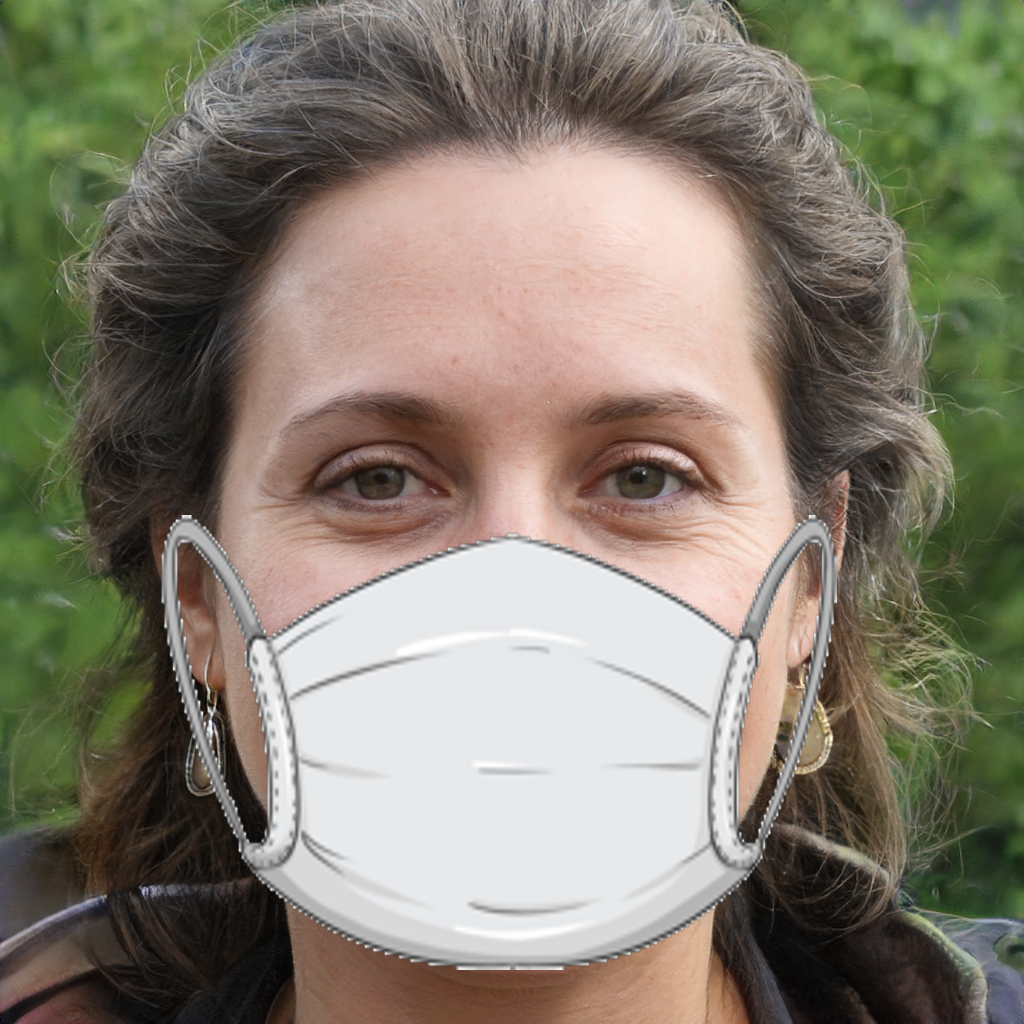

In [19]:
# Zeige Bild
with_mask = list(data_dir.glob('with_mask/*'))
PIL.Image.open(str(with_mask[0]))

Mit `tf.keras.utils.image_dataset_from_directory` kann das Dataset erstellt werden. Die Ordnernamen with_mask und without_mask werden als Klassennamen genommen.

In [21]:
batch_size = 32
img_height = 180
img_width = 180

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,               # dir/with_mask    dir/without_mask 
  validation_split=0.2,   # 20% für Validation
  subset="training",      # Für Training 
  seed=123,
  image_size=(img_height, img_width),  # Kann direkt Größe angeben
  batch_size=batch_size)               # Batchgröße 

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


In [249]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


Das Dataset soll jetzt gespeichert werden (jeder Worker könnte ein Shard speichern und laden).

In [25]:
## Ordner wird erstellt
# - Speichern kann je nach Größe dauern
train_ds.save("./tf_saved_ds", compression="GZIP") # path, compression=None, shard_func=None, checkpoint_args=None

In [26]:
# Lade Dataset
new_ds = tf.data.Dataset.load("./tf_saved_ds", compression="GZIP")

Es kann auch ein Sequenz-Dataset erstellt werden.

In [56]:
# https://www.tensorflow.org/guide/keras/training_with_built_in_methods#training_evaluation_from_tfdata_datasets
# __getitem__() sollte Batches zurückgeben
from  tensorflow.keras.utils import Sequence

class SequenceDS(Sequence):
    def __init__(self, filenames, labels, batch_size):
        # Pfade, ...
        self.data=np.arange(10)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

### 3.1.1 Training mit Dataset Teil 1

In [36]:
%%writefile tf_alexnet.py

from tensorflow.keras import layers, models
import tensorflow as tf
import pathlib

def get_datasets(size:int=3, index:int=0, batch_size:int=32, sharding:bool=True):
    data_dir = pathlib.Path("01work/Datasets/facemask/archive/").with_suffix('')
    print(f"Total Images: {len(list(data_dir.glob('*/*')))}")

    img_height = 224
    img_width  = 224

    if sharding:
        return tf.keras.utils.image_dataset_from_directory(
              data_dir,               # dir/with_mask    dir/without_mask 
              validation_split=0.2,   # 20% für Validation
              subset="training",      # Für Training 
              seed=123,
              image_size=(img_height, img_width),  # Kann direkt Größe angeben
              batch_size=batch_size).shard(size, index),\
            tf.keras.utils.image_dataset_from_directory(
              data_dir,
              validation_split=0.2,
              subset="validation",
              seed=123,
              image_size=(img_height, img_width),
              batch_size=batch_size)
    else: 
         return tf.keras.utils.image_dataset_from_directory(
              data_dir,               # dir/with_mask    dir/without_mask 
              validation_split=0.2,   # 20% für Validation
              subset="training",      # Für Training 
              seed=123,
              image_size=(img_height, img_width),  # Kann direkt Größe angeben
              batch_size=batch_size).shard(size, index),\
            tf.keras.utils.image_dataset_from_directory(
              data_dir,
              validation_split=0.2,
              subset="validation",
              seed=123,
              image_size=(img_height, img_width),
              batch_size=batch_size)


def get_model():
     # AlexNet TensorFlow nach: https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8
     model = models.Sequential()
     model.add(layers.Rescaling(1./255))
     model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(224,224,3)))
     model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
     model.add(layers.Lambda(tf.nn.local_response_normalization))
     model.add(layers.Activation('relu'))
     model.add(layers.MaxPooling2D(3, strides=2))
     model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
     model.add(layers.Lambda(tf.nn.local_response_normalization))
     model.add(layers.Activation('relu'))
     model.add(layers.MaxPooling2D(3, strides=2))
     model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Flatten())
     model.add(layers.Dense(4096, activation='relu'))
     model.add(layers.Dropout(0.5))
     model.add(layers.Dense(4096, activation='relu'))
     model.add(layers.Dropout(0.5))
     model.add(layers.Dense(2, activation='softmax')) # Num Classes

     model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),\
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

     return model


Overwriting tf_alexnet.py


In [7]:
client.upload_file("tf_alexnet.py")  # Lade im Cluster hoch
import tf_alexnet    

In [8]:
def train():

    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  
                             
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    per_worker_batch_size = 64    
    global_batch_size = per_worker_batch_size * strategy.num_replicas_in_sync

    train_set, val_set  = tf_alexnet.get_datasets(int(world_size), int(rank), global_batch_size, sharding=True)  
    
    with strategy.scope():
       multi_worker_model =  tf_alexnet.get_model()  
        
    steps_per_epoch = len(train_set)
    multi_worker_model.fit(train_set, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=val_set) # train_set, epochs=3, steps_per_epoch=70

    tensorflow_tools.save_model(pub, multi_worker_model, "./tf_MWS_Model", "weights")
    if rank ==(0):
        pub.put({'msg': f"Len trainset: {len(train_set)}"}) # Gebe Nachricht aus, wird in Jupyter angezeigt.
    

In [9]:
tensorflow_tools.run(train, client)  

Worker count: 3
Start training



KeyboardInterrupt: 

Als Ergebnis haben wir folgendes: <br>
Mit Sharding: Zeit/Acc= () 

Die Leistung kann mit den Datasets nochmal optimiert werden mit.:<br>


`AUTOTUNE = tf.data.AUTOTUNE`<br>
`train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)`<br>
`val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)`<br>

### 3.1.2 Training mit Dataset Teil 2

Jetzt wird eine andere Möglichtkeit gezeigt Datasets zu erstellen.

In [8]:
%%writefile tf_dataset2.py

from tensorflow.keras import layers, models
import tensorflow as tf
import pathlib
import os

class_names = ['with_mask', 'without_mask']
img_height = 224
img_width  = 224


######################################
# Oder Fasse die Funktionen zusammen #
######################################

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def get_datasets(size:int=3, index:int=0, batch_size:int=32, sharding:bool=True):
    data_dir   = pathlib.Path("01work/Datasets/facemask/archive/").with_suffix('')
    print(f"Total Images: {len(list(data_dir.glob('*/*')))}")
    img_count  = len(list(data_dir.glob('*/*')))
    list_ds    = tf.data.Dataset.list_files(str("01work/Datasets/facemask/archive/*/*"), shuffle=False)  # "01work/Datasets/facemask/archive/*/*"  
    list_ds    = list_ds.shuffle(img_count, reshuffle_each_iteration=False)  

    img_height = 224
    img_width  = 224
    print(f"type img count {type(img_count)}")
    val_size   = int(img_count * 0.2)
    train_ds   = list_ds.skip(val_size)
    val_ds     = list_ds.take(val_size)

    print("Size Train:",tf.data.experimental.cardinality(train_ds).numpy())
    print("Size Val :",tf.data.experimental.cardinality(val_ds).numpy())

    if sharding:
        train_ds = train_ds.shard(size, index).map(process_path).batch(batch_size)#  , num_parallel_calls=AUTOTUNE)
        val_ds   = val_ds.shard(size, index).map(process_path).batch(batch_size)  # , num_parallel_calls=AUTOTUNE)
    else:
        train_ds = train_ds.map(process_path).batch(batch_size)
        val_ds   = val_ds.map(process_path).batch(batch_size)  
     
    return train_ds, val_ds


Overwriting tf_dataset2.py


Dataset mit Optimierungen:

In [9]:
%%writefile tf_dataset2opt.py

from tensorflow.keras import layers, models
import tensorflow as tf
import pathlib
import os

class_names = ['with_mask', 'without_mask']
img_height = 224
img_width  = 224


######################################
# Oder Fasse die Funktionen zusammen #
######################################

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label
    
def get_datasets(size:int=3, index:int=0, batch_size:int=32, sharding:bool=True):
    data_dir   = pathlib.Path("01work/Datasets/facemask/archive/").with_suffix('')
    print(f"Total Images: {len(list(data_dir.glob('*/*')))}")
    img_count  = len(list(data_dir.glob('*/*')))
    list_ds    = tf.data.Dataset.list_files(str("01work/Datasets/facemask/archive/*/*"), shuffle=False)  # "01work/Datasets/facemask/archive/*/*"  
    list_ds    = list_ds.shuffle(img_count, reshuffle_each_iteration=False)  

    img_height = 224
    img_width  = 224
    val_size   = int(img_count * 0.2)
    train_ds   = list_ds.skip(val_size)
    val_ds     = list_ds.take(val_size)

    AUTOTUNE = tf.data.AUTOTUNE
    if sharding:
        train_ds = train_ds.shard(size, index).map(process_path, num_parallel_calls=AUTOTUNE).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
        val_ds   = val_ds.shard(  size, index).map(process_path, num_parallel_calls=AUTOTUNE).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    else:
        train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
        val_ds   = val_ds.map(process_path, num_parallel_calls=AUTOTUNE).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
     
    return train_ds, val_ds


Overwriting tf_dataset2opt.py


In [10]:
%%writefile tf_alexnet_model.py
from tensorflow.keras import layers, models
import tensorflow as tf


def get_model():
     # AlexNet TensorFlow nach: https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8
     model = models.Sequential()
     model.add(layers.Rescaling(1./255))
     model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(224,224,3)))
     model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
     model.add(layers.Lambda(tf.nn.local_response_normalization))
     model.add(layers.Activation('relu'))
     model.add(layers.MaxPooling2D(3, strides=2))
     model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
     model.add(layers.Lambda(tf.nn.local_response_normalization))
     model.add(layers.Activation('relu'))
     model.add(layers.MaxPooling2D(3, strides=2))
     model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Flatten())
     model.add(layers.Dense(4096, activation='relu'))
     model.add(layers.Dropout(0.5))
     model.add(layers.Dense(4096, activation='relu'))
     model.add(layers.Dropout(0.5))
     model.add(layers.Dense(2, activation='softmax')) # Num Classes

     model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),\
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

     return model

Overwriting tf_alexnet_model.py


In [11]:
client.upload_file("tf_dataset2.py") 
import tf_dataset2    
client.upload_file("tf_alexnet_model.py")  
import tf_alexnet_model 
client.upload_file("tf_dataset2opt.py")  
import tf_dataset2opt 

In [12]:
def train():

    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  
                             
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    per_worker_batch_size = 64    
    global_batch_size = per_worker_batch_size * strategy.num_replicas_in_sync

    train_set, val_set  = tf_dataset2opt.get_datasets(int(world_size), int(rank), global_batch_size, sharding=True)  
    
    with strategy.scope():
       multi_worker_model =  tf_alexnet_model.get_model()  
        
    steps_per_epoch = len(train_set)
    multi_worker_model.fit(train_set, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=val_set) # train_set, epochs=3, steps_per_epoch=70

    tensorflow_tools.save_model(pub, multi_worker_model, "./tf_MWS_Model", "weights")
    if rank ==(0):
        pub.put({'msg': f"Len trainset: {len(train_set)}"}) # Gebe Nachricht aus, wird in Jupyter angezeigt.
    

In [11]:
tensorflow_tools.run(train, client)  

Worker count: 3
Start training

Time elapsed: 172.32340383529663
24.11.2023  13:4:49



### 3.1.3 Dataset mit Custom loop und Strategie

Die erstellten Datasets können auch in einer Custom loop genutzt werden. (Loop-Beispiel von oben)

In [12]:
%%writefile tf_alexnet_model_2.py
from tensorflow.keras import layers, models
import tensorflow as tf


def get_model():
     # AlexNet TensorFlow nach: https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8
     model = models.Sequential()
     model.add(layers.Rescaling(1./255))
     model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(224,224,3)))
     model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
     model.add(layers.Lambda(tf.nn.local_response_normalization))
     model.add(layers.Activation('relu'))
     model.add(layers.MaxPooling2D(3, strides=2))
     model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
     model.add(layers.Lambda(tf.nn.local_response_normalization))
     model.add(layers.Activation('relu'))
     model.add(layers.MaxPooling2D(3, strides=2))
     model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
     model.add(layers.Activation('relu'))
     model.add(layers.Flatten())
     model.add(layers.Dense(4096, activation='relu'))
     model.add(layers.Dropout(0.5))
     model.add(layers.Dense(4096, activation='relu'))
     model.add(layers.Dropout(0.5))
     model.add(layers.Dense(2)) # Num Classes

     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),\
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

     return model

Overwriting tf_alexnet_model_2.py


In [13]:
client.upload_file("tf_alexnet_model_2.py")  
import tf_alexnet_model_2

In [15]:

def train():
    import os
    rank = os.environ.get('RANK')    # Rang des Workers
    pub  = Pub("my_channel")         # Channel
    TF_mws_var = os.environ.get('TF_CONFIG')  # Umgebungsvariable für Cluster Config. 
    world_size = os.environ.get('WORLD_SIZE') # Anzahl der Worker  

    epochs = 5
    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * 3
    
    strategy = tensorflow_tools.strategie_MultiWorkerMirrored() 
    
    per_worker_batch_size = 64
    global_batch_size = per_worker_batch_size * strategy.num_replicas_in_sync

    train_dist_dataset, test_dist_dataset  = tf_dataset2opt.get_datasets(int(world_size), int(rank), global_batch_size, sharding=True)


    # Model, Opt, Checkpoint hier
    with strategy.scope():
         # Set reduction to `NONE` so you can do the reduction yourself.
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                 from_logits=True,
                 reduction=tf.keras.losses.Reduction.NONE  # NONE, AUTO
        )
        # Prepare the metrics.
        train_acc_metric = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
        test_acc_metric = keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        test_loss = tf.keras.metrics.Mean(name='test_loss')

        model      = tf_alexnet_model_2.get_model()
        optimizer  = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
        # Berechne Loss
        def compute_loss(labels, predictions, model_losses):
               per_example_loss = loss_object(labels, predictions)
               loss = tf.nn.compute_average_loss(per_example_loss)
               if model_losses:
                    loss += tf.nn.scale_regularization_loss(tf.add_n(model_losses))
               return loss

        for epoch in range(epochs):
             total_loss = 0.0
             num_batches = 0
             start_time = time.time()
             for x in train_dist_dataset:
                 total_loss += strategy_loopfunc.distributed_train_step(x, strategy, model, compute_loss, optimizer, train_acc_metric)
                 num_batches += 1
             train_loss = total_loss / num_batches
             
             # TEST LOOP
             for x in test_dist_dataset:
                  strategy_loopfunc.distributed_test_step(x, strategy, model, loss_object, test_loss, test_acc_metric)

             # Speichern und Ausgabe #
             if epoch % 2 == 0:
                  checkpoint.save("./custom_loop_strategy.ckpt")
             train_acc     =  train_acc_metric.result() * 100
             test_loss_res =  test_loss.result()
             test_acc      =  test_acc_metric.result() * 100
             if rank == "0":
                 msg = f"Epoch ({epoch + 1}/{epochs}), Loss: { train_loss }, Accuracy: { train_acc }, Test Loss: { test_loss_res }, Test Accuracy: { test_acc }"
                 pub.put({'msg': msg})
                 tensorflow_tools.save_model(pub, model, "./tf_MWS_AlexNet_MaskModel", "weights") # weights full
             # Metrik Reset    
             test_loss.reset_states()
             train_acc_metric.reset_states()
             test_acc_metric.reset_states()

In [16]:
tensorflow_tools.run(train, client)  

Worker count: 3
Start training

Epoch (1/5), Loss: 0.6930842995643616, Accuracy: 53.68124771118164, Test Loss: 0.6929057836532593, Test Accuracy: 49.625
Epoch (2/5), Loss: 0.6928501129150391, Accuracy: 56.84375, Test Loss: 0.6926308870315552, Test Accuracy: 49.625
Epoch (3/5), Loss: 0.6925798654556274, Accuracy: 51.58125305175781, Test Loss: 0.6923379898071289, Test Accuracy: 49.625
Epoch (4/5), Loss: 0.6922633051872253, Accuracy: 50.45624923706055, Test Loss: 0.6920043230056763, Test Accuracy: 49.625
Epoch (5/5), Loss: 0.6918849349021912, Accuracy: 50.375003814697266, Test Loss: 0.6916438341140747, Test Accuracy: 49.625
Time elapsed: 191.43628406524658
24.11.2023  15:1:4





<br>

tf.data.Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset <br>
tf.distribute.DistributedDataset: https://www.tensorflow.org/api_docs/python/tf/distribute/DistributedDataset <br>
tf.data: Build TensorFlow input pipelines: https://www.tensorflow.org/guide/data

Load and preprocess images: https://www.tensorflow.org/tutorials/load_data/images <br>
Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance <br>
TFRecord and tf.train.Example: https://www.tensorflow.org/tutorials/load_data/tfrecord

Using a keras.utils.Sequence object as input: https://www.tensorflow.org/guide/keras/training_with_built_in_methods#training_evaluation_from_tfdata_datasets


# 4. Laden und Evaluieren 

Das Model kann jetzt geladen und evaluiert werden.

In [14]:
model  = tf_alexnet_model_2.get_model()

In [15]:
model = keras.models.load_model("tf_MWS_AlexNet_MaskModel.h5")   # Ganzes Model

In [16]:
model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),\
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

Dann kann ein Dataset für das Testen erstellt werden.

In [17]:
data_dir = pathlib.Path("../Datasets/facemask/archive/").with_suffix('')  

batch_size = 32
img_height = 224
img_width = 224

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [18]:
loss, acc = model.evaluate(val_ds, verbose=2)

125/125 - 7s - loss: 5.4960 - accuracy: 0.4915 - 7s/epoch - 56ms/step


In [18]:
latest = tf.train.latest_checkpoint("tf_MWS_AlexNet_MaskModel.weights")

In [19]:
# Nur Gewichte - In Bearbietung -
model.load_weights(latest)

AttributeError: 'NoneType' object has no attribute 'endswith'


<br>

Save and load models: https://www.tensorflow.org/tutorials/keras/save_and_load <br>
Save, serialize, and export models: https://www.tensorflow.org/guide/keras/serialization_and_saving

In [40]:
client.shutdown()